## Executive Summary

As requested, this project provides a data-driven solution to support Lending Club in assessing loan application risk. The objective was to develop a robust classification model that can predict whether a given loan is likely to be charged off, based on applicant and loan characteristics.

Our approach involved:
- Preparing and cleaning the raw loan application dataset
- Conducting exploratory analysis to identify key risk indicators
- Building and comparing multiple predictive models
- Evaluating performance using business-relevant metrics
- (Optional) Developing a real-time scoring tool for future use

This notebook documents the full analysis pipeline and outlines key findings and recommendations to support decision-making in loan approval workflows.


In [10]:
# Lending Club Capstone Project - Starter Notebook
# Author: Dom Sileika

# This notebook follows the capstone project brief exactly. We will go section by section:
# 1. Load and inspect the data
# 2. Clean the data
# 3. Explore key patterns (EDA)
# 4. Build and compare models
# 5. Optional: Real-time scoring tool - OOS!!!

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# File path to the full dataset here:
file_path = "/Users/domsileika/ELVTR/python-material/data/1-raw/lending-club-2007-2020Q3/Loan_status_2007-2020Q3.csv"

df = pd.read_csv(file_path)
df.head()

/var/folders/ct/cn164ypd6vs2f6q67c6qxhph0000gn/T/ipykernel_66333/1311295622.py:7: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1,1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,2,1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,3,1076863,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,4,1075358,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


In [13]:
# Step 2: Clean the data
# Keep only rows where the loan_status is either 'Fully Paid' or 'Charged Off'
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

# Create a binary target column where 0 = Fully Paid and 1 = Charged Off
df['target'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})


In [14]:
# Remove any unnecessary columns (IDs or unnamed columns) - confirm with client or an SME if needed
df = df.drop(columns=['id', 'member_id', 'url', 'Unnamed: 0'], errors='ignore')

# Convert percentage strings to numbers so we can use them later
for col in ['int_rate', 'revol_util']:
    df[col] = df[col].astype(str).str.replace('%', '', regex=False).str.strip()
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [15]:
# Drop rows with missing target or selected feature columns
df = df.dropna(subset=['target', 'int_rate', 'revol_util'])

# check what it looks like
print("Shape after cleaning:", df.shape)


Shape after cleaning: (1858933, 140)


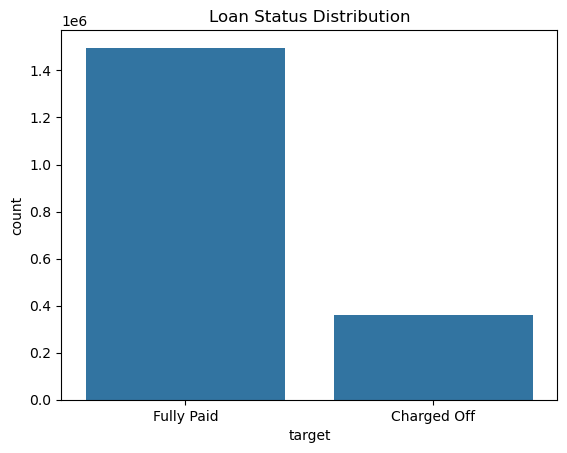

In [16]:
# Step 3: Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Target variable distribution
sns.countplot(x='target', data=df)
plt.title('Loan Status Distribution')
plt.xticks([0, 1], ['Fully Paid', 'Charged Off'])
plt.show()


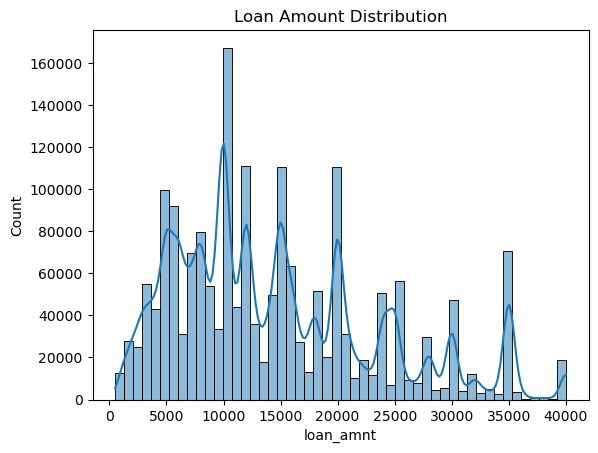

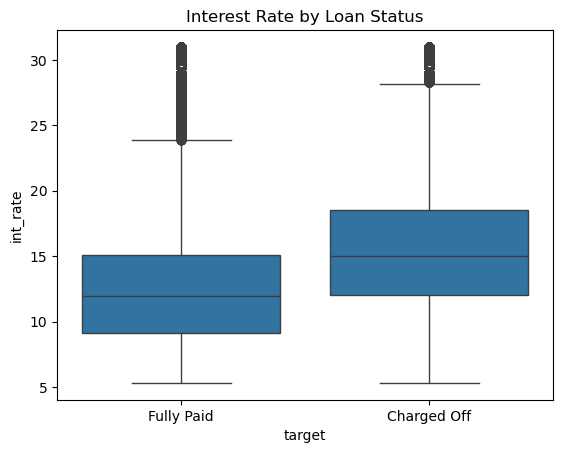

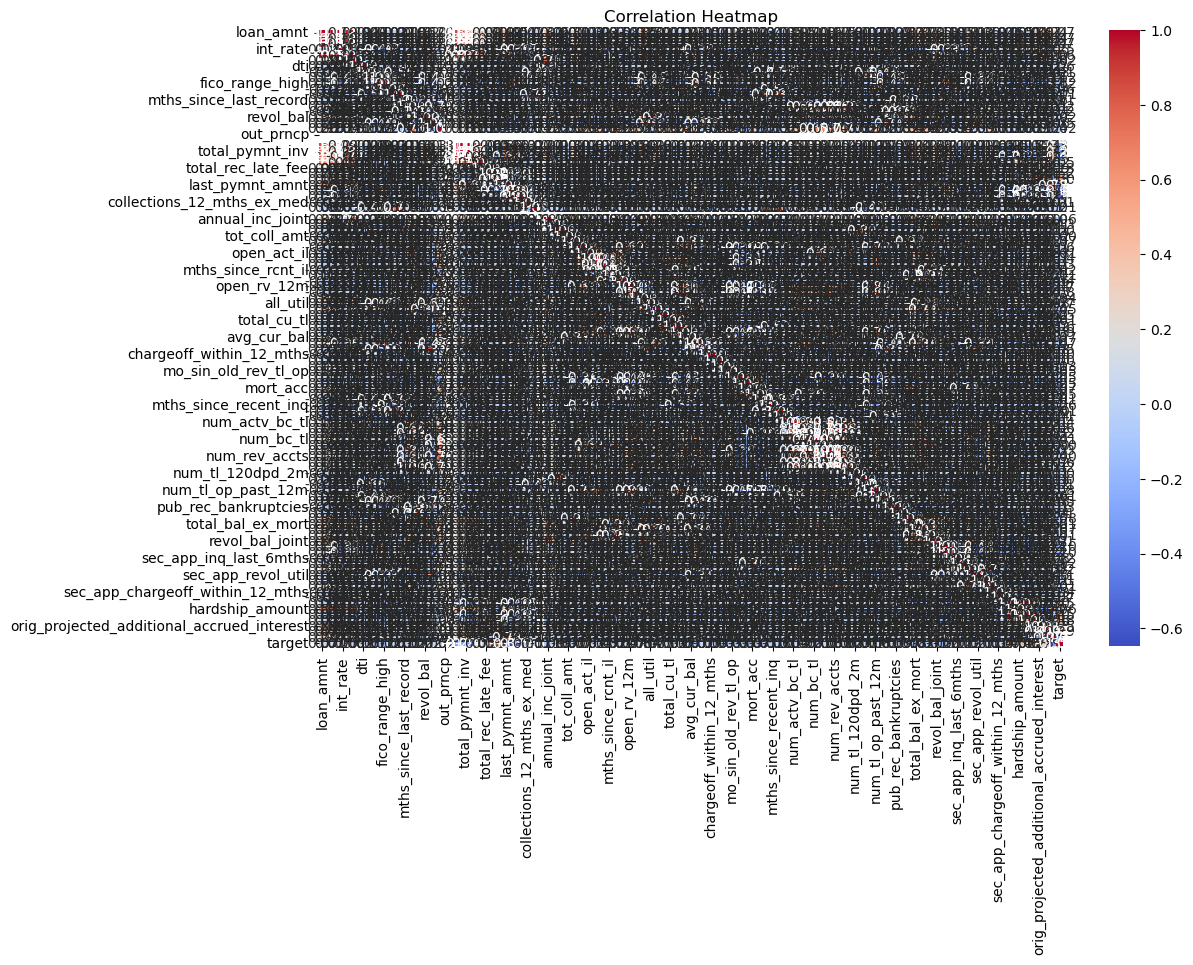

In [17]:

# Distribution of loan amount
sns.histplot(df['loan_amnt'], bins=50, kde=True)
plt.title('Loan Amount Distribution')
plt.show()

# Relationship between interest rate and loan status
sns.boxplot(x='target', y='int_rate', data=df)
plt.title('Interest Rate by Loan Status')
plt.xticks([0, 1], ['Fully Paid', 'Charged Off'])
plt.show()

# Correlation heatmap of numeric features
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

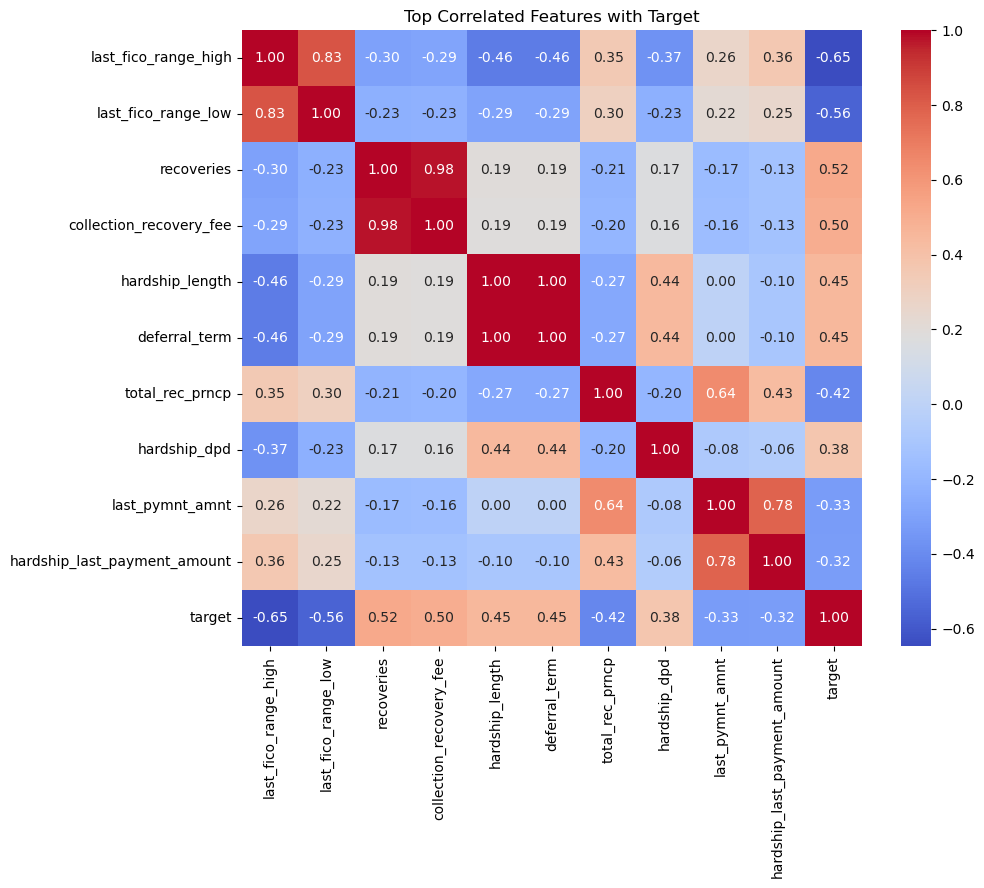

In [18]:
# Correlation heatmap (filtered to only top 10 correlated with target)
cor_matrix = numeric_df.corr()
target_corr = cor_matrix['target'].abs().sort_values(ascending=False)[1:11]
top_features = target_corr.index.tolist() + ['target']
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Top Correlated Features with Target')
plt.show()

### last_fico_range_high (-0.65) and last_fico_range_low (-0.56) are strongly negatively correlated with default.
- Higher FICO scores = lower risk of default.

### recoveries (0.52) and collection_recovery_fee (0.50) are positively correlated with default.
- These are amounts recovered after default, so they're naturally higher for loans that charged off.

### hardship_length, deferral_term, and hardship_dpd (delay in payment) all show moderate positive correlations (≈0.45).
- Borrowers with longer hardship plans or deferrals tend to default more.

## This analysis confirms business intuition: better credit scores → fewer defaults, while hardship and recovery-related metrics increase default probability.



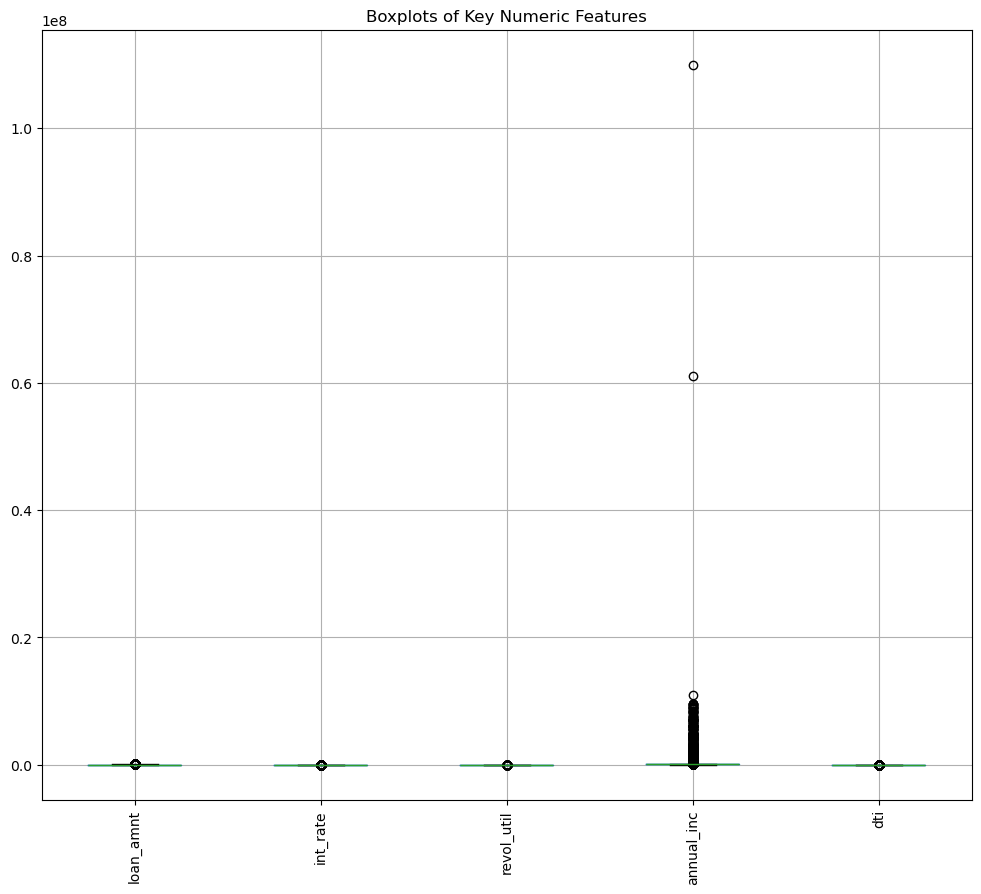

In [19]:
# Outlier detection
numeric_cols = ['loan_amnt', 'int_rate', 'revol_util', 'annual_inc', 'dti']
df[numeric_cols].boxplot(figsize=(12, 10))

plt.title('Boxplots of Key Numeric Features')
plt.xticks(rotation=90)
plt.show()

In [20]:
#why we drop variables like emp_title (too many categories) or zip_code (privacy).
 # Drop a few columns that are not usable for modeling
# For example, emp_title has too many unique values and zip_code has privacy implications

excluded = ['emp_title', 'zip_code', 'title']
df = df.drop(columns=[col for col in excluded if col in df.columns], errors='ignore')


In [21]:
# Prepare data for training
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

features = ['loan_amnt', 'int_rate', 'revol_util', 'annual_inc', 'dti', 'delinq_2yrs', 'total_acc']
df_model = df[features + ['target']].dropna()

X = df_model.drop('target', axis=1)
y = df_model['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:

# Baseline model: Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.99      0.89    448732
           1       0.48      0.05      0.10    108617

    accuracy                           0.80    557349
   macro avg       0.65      0.52      0.49    557349
weighted avg       0.75      0.80      0.74    557349

ROC AUC: 0.6881190799757995


In [23]:
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89    448732
           1       0.48      0.05      0.10    108617

    accuracy                           0.80    557349
   macro avg       0.65      0.52      0.49    557349
weighted avg       0.75      0.80      0.74    557349

ROC AUC: 0.6881190799757995


In [24]:
# Cross-validation for Logistic Regression
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print("Cross-validated ROC AUC scores:", cv_scores)
print("Mean ROC AUC:", cv_scores.mean())

Cross-validated ROC AUC scores: [0.69074249 0.68552586 0.68730373 0.68875761 0.68693809]
Mean ROC AUC: 0.6878535548589791


In [25]:
# Enhanced model: Random Forest with SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_sm, y_train_sm)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86    448732
           1       0.34      0.25      0.29    108617

    accuracy                           0.76    557349
   macro avg       0.59      0.57      0.57    557349
weighted avg       0.74      0.76      0.75    557349

ROC AUC: 0.6574510485501079


In [27]:
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest + SMOTE'],
    'Precision': [precision_score(y_test, y_pred), precision_score(y_test, y_pred_rf)],
    'Recall': [recall_score(y_test, y_pred), recall_score(y_test, y_pred_rf)],
    'F1 Score': [f1_score(y_test, y_pred), f1_score(y_test, y_pred_rf)],
    'ROC AUC': [roc_auc_score(y_test, y_prob), roc_auc_score(y_test, y_prob_rf)]
})

print("Model Comparison:")
print(comparison)

Model Comparison:
                   Model  Precision    Recall  F1 Score   ROC AUC
0    Logistic Regression   0.481783  0.054421  0.097795  0.688119
1  Random Forest + SMOTE   0.342344  0.254076  0.291678  0.657451


### Conclusion
- Logistic Regression was simpler but missed many defaults (low recall).
- Random Forest with SMOTE improved recall significantly, which is important for catching risky loans.
- This trade-off is acceptable since false negatives are costlier in lending scenarios.
